In [1]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras import optimizers

Using TensorFlow backend.


In [2]:
data = pd.read_csv('./data.csv',header=None,names=['IP','Throughput'])

In [3]:
data.head()

,IP,Throughput
0,69.12.74.28,399 KB/s
1,69.12.74.28,352 KB/s
2,23.229.191.68,235 KB/s
3,104.31.71.147,5.14 MB/s
4,192.186.249.52,832 KB/s


In [4]:
rows_with_KB=data['Throughput'].str.contains('KB/s')

for tp in range(len(data['Throughput'])):
    data['Throughput'][tp] = data['Throughput'][tp][:-5]
    if rows_with_KB[tp]==True:
        data['Throughput'][tp] = float(data['Throughput'][tp])
        data['Throughput'][tp] /= 1024
        data['Throughput'][tp] ='%.2f' %data['Throughput'][tp]    

print(data.rename(columns={'Throughput':'Throughput(MB/s)'}))

                  IP Throughput(MB/s)
0        69.12.74.28             0.39
1        69.12.74.28             0.34
2      23.229.191.68             0.23
3      104.31.71.147             5.14
4     192.186.249.52             0.81
...              ...              ...
4287   91.191.149.39             18.3
4288   173.254.28.92             0.10
4289   173.254.28.92             0.14
4290   209.124.66.12             4.74
4291    62.210.16.62             5.64

[4292 rows x 2 columns]


In [5]:
data['Throughput']=pd.to_numeric(data['Throughput'])
processed_data=data.groupby(['IP']).mean()['Throughput']
print(processed_data)
processed_data.to_csv('processed_data.csv')

IP
1.33.172.30        0.110000
100.42.49.232      0.410000
101.0.119.44       0.060000
101.99.75.132      0.150000
102.133.174.201    0.680000
                     ...   
98.142.109.50      3.236667
98.142.110.26      2.018571
98.142.110.28      0.270000
98.159.40.82       0.550000
99.86.116.83       0.750000
Name: Throughput, Length: 3292, dtype: float64


C:\Users\aqua2018\Anaconda3\envs\SNS\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


In [6]:
data = pd.read_csv('./processed_data.csv',header=None,names=['IP','Throughput(MB/s)'])
data['IP in 32 bit']=None
for i in range(len(data['IP'])):    
    data['IP in 32 bit'][i]=''.join('{:08b}'.format(int(n)) for n in data['IP'][i].split('.'))

print(data)
data.to_csv('processed_data.csv')

C:\Users\aqua2018\Anaconda3\envs\SNS\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


                   IP  Throughput(MB/s)                      IP in 32 bit
0         1.33.172.30          0.110000  00000001001000011010110000011110
1       100.42.49.232          0.410000  01100100001010100011000111101000
2        101.0.119.44          0.060000  01100101000000000111011100101100
3       101.99.75.132          0.150000  01100101011000110100101110000100
4     102.133.174.201          0.680000  01100110100001011010111011001001
...               ...               ...                               ...
3287    98.142.109.50          3.236667  01100010100011100110110100110010
3288    98.142.110.26          2.018571  01100010100011100110111000011010
3289    98.142.110.28          0.270000  01100010100011100110111000011100
3290     98.159.40.82          0.550000  01100010100111110010100001010010
3291     99.86.116.83          0.750000  01100011010101100111010001010011

[3292 rows x 3 columns]


In [7]:
from sklearn.model_selection import train_test_split

data = pd.read_csv('./processed_data.csv')
ip=[]
for b in data['IP in 32 bit']:
    listb=list(b)
    ip.append(listb)
    
X=np.array(ip)
Y=np.array(data['Throughput(MB/s)'])
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=0)
x_train=x_train.astype('int')
x_test=x_test.astype('int')

print(x_train.shape)
print(x_test.shape)

(2633, 32)
(659, 32)


In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

learning_rate=[0.001,0.005,0.01]
batch_size=[16,32,64,128]
epochs=[5,10,20,50]
act_fcn=['relu','tanh','sigmoid']

for lr in learning_rate:
    for batch in batch_size:
        for epoch in range(1,51): 
            for act in act_fcn:
                sgd=optimizers.sgd(lr=lr) 
                
                #k-fold cross validation
                kfold=KFold(n_splits=3,shuffle=True,random_state=0)
                mselist=[]
                
                for train_idx,test_idx in kfold.split(x_train,y_train):
                    model=Sequential()
                    model.add(Dense(64, activation=act, input_dim=32))
                    model.add(Dense(1))
                    model.compile(loss='mse',optimizer=sgd)    
                    model.fit(x_train[train_idx],y_train[train_idx],epochs=epoch,batch_size=batch)
                    mse=model.evaluate(x_train[test_idx],y_train[test_idx])
                    mselist.append(mse)
                
                with open ('mse.csv','a') as f:
                    string='{},{},{},{},{}'.format(lr,batch,epoch,act,np.mean(mselist))
                    f.write(string+'\n')


Epoch 1/1
878/878 [==============================] - 1s 1ms/step
Epoch 1/1
878/878 [==============================] - 1s 2ms/step
Epoch 1/1
877/877 [==============================] - 1s 1ms/step
Epoch 1/1
878/878 [==============================] - 1s 1ms/step
Epoch 1/1
878/878 [==============================] - 1s 2ms/step
Epoch 1/1
877/877 [==============================] - 1s 1ms/step
Epoch 1/2
1755/1755 [==============================] - 4s 2ms/step - loss: 53.2376
Epoch 2/2
878/878 [==============================] - 1s 2ms/step
Epoch 1/2
1755/1755 [==============================] - 3s 2ms/step - loss: 48.3981
Epoch 2/2
878/878 [==============================] - 1s 1ms/step
Epoch 1/2
1756/1756 [==============================] - 3s 2ms/step - loss: 57.4949
Epoch 2/2
877/877 [==============================] - 1s 1ms/step
Epoch 1/2
1755/1755 [==============================] - 3s 2ms/step - loss: 52.8193
Epoch 2/2
878/878 [==============================] - 1s 1ms/step
Epoch 1/2
1755/175

878/878 [==============================] - 1s 2ms/step
Epoch 1/5
1755/1755 [==============================] - 4s 2ms/step - loss: 48.1493
Epoch 2/5
1755/1755 [==============================] - 0s 122us/step - loss: 45.4303
Epoch 3/5
1755/1755 [==============================] - 0s 124us/step - loss: 45.3663
Epoch 4/5
1755/1755 [==============================] - 0s 126us/step - loss: 45.3166
Epoch 5/5
878/878 [==============================] - 1s 2ms/step
Epoch 1/5
1756/1756 [==============================] - 4s 2ms/step - loss: 58.7375
Epoch 2/5
1756/1756 [==============================] - 0s 91us/step - loss: 54.3748
Epoch 3/5
1756/1756 [==============================] - 0s 81us/step - loss: 54.2860
Epoch 4/5
1756/1756 [==============================] - 0s 80us/step - loss: 54.2353
Epoch 5/5
877/877 [==============================] - 1s 2ms/step
Epoch 1/6
1755/1755 [==============================] - 4s 2ms/step - loss: 54.1497
Epoch 2/6
1755/1755 [==============================] - 0s 9

Epoch 6/9
1755/1755 [==============================] - 1s 382us/step - loss: 45.2941
Epoch 7/9
1755/1755 [==============================] - 0s 169us/step - loss: 45.2679
Epoch 8/9
1755/1755 [==============================] - 0s 195us/step - loss: 45.2982
Epoch 9/9
878/878 [==============================] - 3s 3ms/step
Epoch 1/9
1756/1756 [==============================] - 6s 4ms/step - loss: 57.6791
Epoch 2/9
1756/1756 [==============================] - 0s 148us/step - loss: 54.3594
Epoch 3/9
1756/1756 [==============================] - 0s 160us/step - loss: 54.3273
Epoch 4/9
1756/1756 [==============================] - 0s 173us/step - loss: 54.2785
Epoch 5/9
1756/1756 [==============================] - 0s 152us/step - loss: 54.2718
Epoch 6/9
1756/1756 [==============================] - 0s 154us/step - loss: 54.2570
Epoch 7/9
1756/1756 [==============================] - 0s 158us/step - loss: 54.2259
Epoch 8/9
1756/1756 [==============================] - 0s 172us/step - loss: 54.1936
Ep

1755/1755 [==============================] - 0s 198us/step - loss: 44.9690
Epoch 7/11
1755/1755 [==============================] - 0s 207us/step - loss: 44.9549
Epoch 8/11
1755/1755 [==============================] - 0s 195us/step - loss: 44.8637
Epoch 9/11
1755/1755 [==============================] - 0s 225us/step - loss: 44.7975
Epoch 10/11
1755/1755 [==============================] - 0s 258us/step - loss: 44.7306
Epoch 11/11
878/878 [==============================] - 3s 3ms/step
Epoch 1/11
1756/1756 [==============================] - 7s 4ms/step - loss: 58.2493
Epoch 2/11
1756/1756 [==============================] - 0s 194us/step - loss: 54.1982
Epoch 3/11
1756/1756 [==============================] - 0s 152us/step - loss: 54.0382
Epoch 4/11
1756/1756 [==============================] - 0s 184us/step - loss: 53.8758
Epoch 5/11
1756/1756 [==============================] - 0s 189us/step - loss: 53.7458
Epoch 6/11
1756/1756 [==============================] - 0s 193us/step - loss: 53.6157

Epoch 6/13
1755/1755 [==============================] - 0s 257us/step - loss: 45.4403
Epoch 7/13
1755/1755 [==============================] - 0s 246us/step - loss: 45.3667
Epoch 8/13
1755/1755 [==============================] - 0s 240us/step - loss: 45.4170
Epoch 9/13
1755/1755 [==============================] - 0s 246us/step - loss: 45.40340s - los
Epoch 10/13
1755/1755 [==============================] - 0s 267us/step - loss: 45.3539
Epoch 11/13
1755/1755 [==============================] - 0s 244us/step - loss: 45.3828
Epoch 12/13
1755/1755 [==============================] - 0s 246us/step - loss: 45.3514
Epoch 13/13
878/878 [==============================] - 4s 4ms/step
Epoch 1/13
1756/1756 [==============================] - 30s 17ms/step - loss: 61.5404:  - E
Epoch 2/13
1756/1756 [==============================] - 6s 3ms/step - loss: 54.4652
Epoch 3/13
1756/1756 [==============================] - 6s 3ms/step - loss: 54.2678: 0s - loss: 5
Epoch 4/13
1756/1756 [========================

1755/1755 [==============================] - 0s 145us/step - loss: 45.2775
Epoch 8/15
1755/1755 [==============================] - 0s 128us/step - loss: 45.2709
Epoch 9/15
1755/1755 [==============================] - 0s 137us/step - loss: 45.2417
Epoch 10/15
1755/1755 [==============================] - 0s 132us/step - loss: 45.2490
Epoch 11/15
1755/1755 [==============================] - 0s 142us/step - loss: 45.2223
Epoch 12/15
1755/1755 [==============================] - 0s 137us/step - loss: 45.2073
Epoch 13/15
1755/1755 [==============================] - 0s 136us/step - loss: 45.1834
Epoch 14/15
1755/1755 [==============================] - 0s 136us/step - loss: 45.1699
Epoch 15/15
878/878 [==============================] - 2s 3ms/step
Epoch 1/15
1756/1756 [==============================] - 6s 3ms/step - loss: 56.1670
Epoch 2/15
1756/1756 [==============================] - 0s 148us/step - loss: 54.4097
Epoch 3/15
1756/1756 [==============================] - 0s 103us/step - loss: 54.

1755/1755 [==============================] - 0s 104us/step - loss: 45.3051
Epoch 3/16
1755/1755 [==============================] - 0s 101us/step - loss: 45.2654
Epoch 4/16
1755/1755 [==============================] - 0s 100us/step - loss: 45.2694
Epoch 5/16
1755/1755 [==============================] - 0s 94us/step - loss: 45.2410
Epoch 6/16
1755/1755 [==============================] - 0s 97us/step - loss: 45.2033
Epoch 7/16
1755/1755 [==============================] - 0s 98us/step - loss: 45.2340
Epoch 8/16
1755/1755 [==============================] - 0s 90us/step - loss: 45.2230
Epoch 9/16
1755/1755 [==============================] - 0s 88us/step - loss: 45.2045
Epoch 10/16
1755/1755 [==============================] - 0s 97us/step - loss: 45.1701
Epoch 11/16
1755/1755 [==============================] - 0s 93us/step - loss: 45.1652
Epoch 12/16
1755/1755 [==============================] - 0s 109us/step - loss: 45.1608
Epoch 13/16
1755/1755 [==============================] - 0s 111us/ste

1756/1756 [==============================] - 0s 104us/step - loss: 53.0195
Epoch 13/18
1756/1756 [==============================] - 0s 105us/step - loss: 52.9759
Epoch 14/18
1756/1756 [==============================] - ETA: 0s - loss: 46.48 - 0s 106us/step - loss: 52.9273
Epoch 15/18
1756/1756 [==============================] - 0s 105us/step - loss: 52.85950s - loss: 5
Epoch 16/18
1756/1756 [==============================] - ETA: 0s - loss: 52.47 - 0s 102us/step - loss: 52.8280
Epoch 17/18
1756/1756 [==============================] - 0s 127us/step - loss: 52.8054
Epoch 18/18
877/877 [==============================] - 2s 2ms/step
Epoch 1/18
1755/1755 [==============================] - 6s 3ms/step - loss: 53.0614
Epoch 2/18
1755/1755 [==============================] - 0s 112us/step - loss: 50.3473
Epoch 3/18
1755/1755 [==============================] - 0s 98us/step - loss: 50.3192
Epoch 4/18
1755/1755 [==============================] - 0s 103us/step - loss: 50.3034
Epoch 5/18
1755/1755 [

1755/1755 [==============================] - 0s 226us/step - loss: 49.9971
Epoch 8/20
1755/1755 [==============================] - 0s 266us/step - loss: 49.8766
Epoch 9/20
1755/1755 [==============================] - 0s 211us/step - loss: 49.7955
Epoch 10/20
1755/1755 [==============================] - 0s 210us/step - loss: 49.7621
Epoch 11/20
1755/1755 [==============================] - 0s 207us/step - loss: 49.6773
Epoch 12/20
1755/1755 [==============================] - 0s 179us/step - loss: 49.6030
Epoch 13/20
1755/1755 [==============================] - 1s 296us/step - loss: 49.5741
Epoch 14/20
1755/1755 [==============================] - 0s 240us/step - loss: 49.5183
Epoch 15/20
1755/1755 [==============================] - 0s 186us/step - loss: 49.4569
Epoch 16/20
1755/1755 [==============================] - 0s 204us/step - loss: 49.4096
Epoch 17/20
1755/1755 [==============================] - 0s 211us/step - loss: 49.3164
Epoch 18/20
1755/1755 [==============================] - 

877/877 [==============================] - 12s 14ms/step
Epoch 1/21
1755/1755 [==============================] - 6s 4ms/step - loss: 51.8595
Epoch 2/21
1755/1755 [==============================] - 0s 139us/step - loss: 50.4774
Epoch 3/21
1755/1755 [==============================] - 0s 139us/step - loss: 50.4253
Epoch 4/21
1755/1755 [==============================] - 0s 121us/step - loss: 50.4007
Epoch 5/21
1755/1755 [==============================] - 0s 111us/step - loss: 50.3885
Epoch 6/21
1755/1755 [==============================] - 0s 112us/step - loss: 50.3805
Epoch 7/21
1755/1755 [==============================] - 0s 110us/step - loss: 50.3702
Epoch 8/21
1755/1755 [==============================] - 0s 111us/step - loss: 50.3208
Epoch 9/21
1755/1755 [==============================] - 0s 111us/step - loss: 50.3342
Epoch 10/21
1755/1755 [==============================] - 0s 108us/step - loss: 50.2635
Epoch 11/21
1755/1755 [==============================] - 0s 131us/step - loss: 50.30

1755/1755 [==============================] - 0s 174us/step - loss: 45.1866
Epoch 7/22
1755/1755 [==============================] - 0s 178us/step - loss: 45.1462
Epoch 8/22
1755/1755 [==============================] - 0s 155us/step - loss: 45.0746
Epoch 9/22
1755/1755 [==============================] - 0s 148us/step - loss: 44.9259
Epoch 10/22
1755/1755 [==============================] - 0s 138us/step - loss: 44.9473
Epoch 11/22
1755/1755 [==============================] - 0s 141us/step - loss: 44.8729
Epoch 12/22
1755/1755 [==============================] - 0s 138us/step - loss: 44.8206
Epoch 13/22
1755/1755 [==============================] - 0s 136us/step - loss: 44.7699
Epoch 14/22
1755/1755 [==============================] - 0s 144us/step - loss: 44.7461
Epoch 15/22
1755/1755 [==============================] - 0s 140us/step - loss: 44.7017
Epoch 16/22
1755/1755 [==============================] - 0s 162us/step - loss: 44.6601
Epoch 17/22
1755/1755 [==============================] - 0

1755/1755 [==============================] - 0s 220us/step - loss: 50.3263
Epoch 10/23
1755/1755 [==============================] - 0s 170us/step - loss: 50.3136
Epoch 11/23
1755/1755 [==============================] - 0s 231us/step - loss: 50.3120
Epoch 12/23
1755/1755 [==============================] - 0s 159us/step - loss: 50.3072
Epoch 13/23
1755/1755 [==============================] - 0s 121us/step - loss: 50.2637
Epoch 14/23
1755/1755 [==============================] - 0s 144us/step - loss: 50.2745
Epoch 15/23
1755/1755 [==============================] - 0s 142us/step - loss: 50.24230s - loss:
Epoch 16/23
1755/1755 [==============================] - 0s 136us/step - loss: 50.2302
Epoch 17/23
1755/1755 [==============================] - 0s 140us/step - loss: 50.2289
Epoch 18/23
1755/1755 [==============================] - 0s 142us/step - loss: 50.2017
Epoch 19/23
1755/1755 [==============================] - 0s 128us/step - loss: 50.1870
Epoch 20/23
1755/1755 [======================

1756/1756 [==============================] - 8s 5ms/step - loss: 58.8194
Epoch 2/24
1756/1756 [==============================] - 0s 131us/step - loss: 54.3129 0s - loss: 59.
Epoch 3/24
1756/1756 [==============================] - 0s 235us/step - loss: 54.2094
Epoch 4/24
1756/1756 [==============================] - ETA: 0s - loss: 55.91 - 0s 132us/step - loss: 54.1818
Epoch 5/24
1756/1756 [==============================] - 0s 187us/step - loss: 54.1596
Epoch 6/24
1756/1756 [==============================] - 0s 224us/step - loss: 54.1615
Epoch 7/24
1756/1756 [==============================] - 0s 160us/step - loss: 54.1190
Epoch 8/24
1756/1756 [==============================] - 0s 160us/step - loss: 54.0863
Epoch 9/24
1756/1756 [==============================] - 0s 225us/step - loss: 54.08670s - loss:
Epoch 10/24
1756/1756 [==============================] - 0s 162us/step - loss: 54.0874
Epoch 11/24
1756/1756 [==============================] - 0s 247us/step - loss: 54.0603
Epoch 12/24
1756

Epoch 18/25
1756/1756 [==============================] - 0s 158us/step - loss: 52.9141
Epoch 19/25
1756/1756 [==============================] - 0s 179us/step - loss: 52.8598
Epoch 20/25
1756/1756 [==============================] - 0s 169us/step - loss: 52.8472
Epoch 21/25
1756/1756 [==============================] - 0s 201us/step - loss: 52.82760s - l
Epoch 22/25
1756/1756 [==============================] - 0s 173us/step - loss: 52.7944
Epoch 23/25
1756/1756 [==============================] - 0s 153us/step - loss: 52.7676
Epoch 24/25
1756/1756 [==============================] - 0s 173us/step - loss: 52.7769
Epoch 25/25
877/877 [==============================] - 3s 3ms/step
Epoch 1/25
1755/1755 [==============================] - 7s 4ms/step - loss: 54.2096
Epoch 2/25
1755/1755 [==============================] - 0s 117us/step - loss: 50.5021
Epoch 3/25
1755/1755 [==============================] - 0s 107us/step - loss: 50.4214
Epoch 4/25
1755/1755 [==============================] - 0s 104

1755/1755 [==============================] - 0s 123us/step - loss: 50.0898
Epoch 24/26
1755/1755 [==============================] - 0s 115us/step - loss: 50.0343
Epoch 25/26
1755/1755 [==============================] - 0s 114us/step - loss: 50.0507
Epoch 26/26
878/878 [==============================] - 3s 3ms/step
Epoch 1/26
1755/1755 [==============================] - 7s 4ms/step - loss: 46.9810
Epoch 2/26
1755/1755 [==============================] - 0s 124us/step - loss: 45.4079
Epoch 3/26
1755/1755 [==============================] - 0s 110us/step - loss: 45.3749
Epoch 4/26
1755/1755 [==============================] - 0s 106us/step - loss: 45.3445
Epoch 5/26
1755/1755 [==============================] - 0s 109us/step - loss: 45.30910s - loss: 46.27
Epoch 6/26
1755/1755 [==============================] - 0s 113us/step - loss: 45.3245
Epoch 7/26
1755/1755 [==============================] - 0s 112us/step - loss: 45.3105
Epoch 8/26
1755/1755 [==============================] - 0s 113us/ste

1755/1755 [==============================] - 0s 156us/step - loss: 45.1005
Epoch 20/27
1755/1755 [==============================] - 0s 138us/step - loss: 45.0838
Epoch 21/27
1755/1755 [==============================] - 1s 313us/step - loss: 45.0802
Epoch 22/27
1755/1755 [==============================] - 1s 490us/step - loss: 45.0688
Epoch 23/27
1755/1755 [==============================] - 1s 305us/step - loss: 45.0682
Epoch 24/27
1755/1755 [==============================] - 0s 173us/step - loss: 45.0433
Epoch 25/27
1755/1755 [==============================] - 0s 182us/step - loss: 45.0439
Epoch 26/27
1755/1755 [==============================] - 0s 168us/step - loss: 45.0321
Epoch 27/27
878/878 [==============================] - 4s 4ms/step
Epoch 1/27
1756/1756 [==============================] - 8s 4ms/step - loss: 56.7641
Epoch 2/27
1756/1756 [==============================] - 0s 158us/step - loss: 54.2510
Epoch 3/27
1756/1756 [==============================] - 0s 127us/step - loss: 5

1756/1756 [==============================] - 0s 133us/step - loss: 54.1954
Epoch 8/28
1756/1756 [==============================] - 0s 133us/step - loss: 54.1675
Epoch 9/28
1756/1756 [==============================] - 0s 133us/step - loss: 54.1588
Epoch 10/28
1756/1756 [==============================] - 0s 202us/step - loss: 54.1566
Epoch 11/28
1756/1756 [==============================] - 0s 154us/step - loss: 54.0976
Epoch 12/28
1756/1756 [==============================] - 0s 189us/step - loss: 54.0821
Epoch 13/28
1756/1756 [==============================] - 0s 145us/step - loss: 54.0696
Epoch 14/28
1756/1756 [==============================] - 0s 162us/step - loss: 54.0330
Epoch 15/28
1756/1756 [==============================] - 0s 149us/step - loss: 54.0404
Epoch 16/28
1756/1756 [==============================] - 0s 151us/step - loss: 53.9918
Epoch 17/28
1756/1756 [==============================] - 0s 137us/step - loss: 53.9892
Epoch 18/28
1756/1756 [==============================] - 

1756/1756 [==============================] - 0s 136us/step - loss: 54.0705
Epoch 19/29
1756/1756 [==============================] - 0s 174us/step - loss: 54.0200
Epoch 20/29
1756/1756 [==============================] - 1s 289us/step - loss: 54.0493
Epoch 21/29
1756/1756 [==============================] - 0s 118us/step - loss: 54.0021
Epoch 22/29
1756/1756 [==============================] - 0s 122us/step - loss: 54.0325
Epoch 23/29
1756/1756 [==============================] - 0s 118us/step - loss: 53.9821
Epoch 24/29
1756/1756 [==============================] - 0s 140us/step - loss: 53.9655
Epoch 25/29
1756/1756 [==============================] - 0s 122us/step - loss: 53.9913
Epoch 26/29
1756/1756 [==============================] - 0s 116us/step - loss: 53.9303
Epoch 27/29
1756/1756 [==============================] - 0s 123us/step - loss: 53.9219
Epoch 28/29
1756/1756 [==============================] - 0s 118us/step - loss: 53.9283
Epoch 29/29
877/877 [==============================] - 

1756/1756 [==============================] - 0s 146us/step - loss: 53.9981
Epoch 22/30
1756/1756 [==============================] - 0s 130us/step - loss: 54.0081
Epoch 23/30
1756/1756 [==============================] - 0s 130us/step - loss: 53.9639
Epoch 24/30
1756/1756 [==============================] - 0s 139us/step - loss: 53.9191 0s - loss: 7
Epoch 25/30
1756/1756 [==============================] - 0s 140us/step - loss: 53.9385
Epoch 26/30
1756/1756 [==============================] - 0s 117us/step - loss: 53.9205
Epoch 27/30
1756/1756 [==============================] - 0s 136us/step - loss: 53.9069
Epoch 28/30
1756/1756 [==============================] - ETA: 0s - loss: 54.87 - 0s 136us/step - loss: 53.8983
Epoch 29/30
1756/1756 [==============================] - 0s 132us/step - loss: 53.8935
Epoch 30/30
877/877 [==============================] - 4s 5ms/step
Epoch 1/31
1755/1755 [==============================] - 10s 6ms/step - loss: 54.9603
Epoch 2/31
1755/1755 [==================

1756/1756 [==============================] - 0s 132us/step - loss: 53.9930
Epoch 18/31
1756/1756 [==============================] - 0s 120us/step - loss: 53.9793
Epoch 19/31
1756/1756 [==============================] - 1s 360us/step - loss: 53.9606
Epoch 20/31
1756/1756 [==============================] - 1s 402us/step - loss: 53.9335
Epoch 21/31
1756/1756 [==============================] - 1s 460us/step - loss: 53.9291 0s - loss: 5 - ETA: 
Epoch 22/31
1756/1756 [==============================] - 0s 172us/step - loss: 53.9126
Epoch 23/31
1756/1756 [==============================] - 0s 166us/step - loss: 53.8782
Epoch 24/31
1756/1756 [==============================] - 0s 133us/step - loss: 53.8780
Epoch 25/31
1756/1756 [==============================] - 0s 135us/step - loss: 53.8603
Epoch 26/31
1756/1756 [==============================] - 0s 119us/step - loss: 53.8148
Epoch 27/31
1756/1756 [==============================] - 0s 273us/step - loss: 53.8322
Epoch 28/31
1756/1756 [===========

1756/1756 [==============================] - 0s 136us/step - loss: 54.2438
Epoch 6/32
1756/1756 [==============================] - 0s 137us/step - loss: 54.2403
Epoch 7/32
1756/1756 [==============================] - 0s 132us/step - loss: 54.2080
Epoch 8/32
1756/1756 [==============================] - 0s 128us/step - loss: 54.2056
Epoch 9/32
1756/1756 [==============================] - ETA: 0s - loss: 56.9168 ETA: 0s - loss: 55. - 0s 136us/step - loss: 54.1812
Epoch 10/32
1756/1756 [==============================] - 0s 278us/step - loss: 54.1490
Epoch 11/32
1756/1756 [==============================] - ETA: 0s - loss: 57.39 - 0s 143us/step - loss: 54.1147
Epoch 12/32
1756/1756 [==============================] - 0s 158us/step - loss: 54.1217
Epoch 13/32
1756/1756 [==============================] - 0s 131us/step - loss: 54.1082
Epoch 14/32
1756/1756 [==============================] - 0s 134us/step - loss: 54.0724
Epoch 15/32
1756/1756 [==============================] - ETA: 0s - loss: 55.

1755/1755 [==============================] - 0s 239us/step - loss: 45.0502
Epoch 21/33
1755/1755 [==============================] - 0s 245us/step - loss: 45.0377
Epoch 22/33
1755/1755 [==============================] - 0s 176us/step - loss: 45.0276
Epoch 23/33
1755/1755 [==============================] - 0s 223us/step - loss: 45.0097
Epoch 24/33
1755/1755 [==============================] - 0s 230us/step - loss: 45.0012
Epoch 25/33
1755/1755 [==============================] - 1s 543us/step - loss: 44.99550s - loss: 42.64
Epoch 26/33
1755/1755 [==============================] - 1s 474us/step - loss: 45.00230s - los
Epoch 27/33
1755/1755 [==============================] - 1s 491us/step - loss: 44.99570s - loss: 4
Epoch 28/33
1755/1755 [==============================] - 1s 333us/step - loss: 44.9600
Epoch 29/33
1755/1755 [==============================] - 0s 241us/step - loss: 44.9459
Epoch 30/33
1755/1755 [==============================] - 1s 298us/step - loss: 44.9464
Epoch 31/33
1755/17

1755/1755 [==============================] - 0s 149us/step - loss: 44.66920s - loss: 36.
Epoch 12/34
1755/1755 [==============================] - 0s 175us/step - loss: 44.6371
Epoch 13/34
1755/1755 [==============================] - 0s 138us/step - loss: 44.5987
Epoch 14/34
1755/1755 [==============================] - 0s 136us/step - loss: 44.5180
Epoch 15/34
1755/1755 [==============================] - 0s 149us/step - loss: 44.5387
Epoch 16/34
1755/1755 [==============================] - 0s 223us/step - loss: 44.4466
Epoch 17/34
1755/1755 [==============================] - 0s 193us/step - loss: 44.4306
Epoch 18/34
1755/1755 [==============================] - 0s 164us/step - loss: 44.4258
Epoch 19/34
1755/1755 [==============================] - 0s 176us/step - loss: 44.3849
Epoch 20/34
1755/1755 [==============================] - 0s 167us/step - loss: 44.3513
Epoch 21/34
1755/1755 [==============================] - 0s 161us/step - loss: 44.3407
Epoch 22/34
1755/1755 [==================

1755/1755 [==============================] - 0s 119us/step - loss: 49.1279
Epoch 21/35
1755/1755 [==============================] - 0s 110us/step - loss: 49.1223
Epoch 22/35
1755/1755 [==============================] - 0s 130us/step - loss: 49.1104
Epoch 23/35
1755/1755 [==============================] - 0s 136us/step - loss: 49.0983
Epoch 24/35
1755/1755 [==============================] - 0s 122us/step - loss: 49.07160s - loss: 42.
Epoch 25/35
1755/1755 [==============================] - 0s 109us/step - loss: 49.0603
Epoch 26/35
1755/1755 [==============================] - 0s 141us/step - loss: 49.0287
Epoch 27/35
1755/1755 [==============================] - 0s 180us/step - loss: 49.0516
Epoch 28/35
1755/1755 [==============================] - 0s 146us/step - loss: 48.9848
Epoch 29/35
1755/1755 [==============================] - 0s 169us/step - loss: 49.0317
Epoch 30/35
1755/1755 [==============================] - 1s 295us/step - loss: 48.9790
Epoch 31/35
1755/1755 [==================

1756/1756 [==============================] - 0s 276us/step - loss: 53.86230s - loss: 5
Epoch 28/35
1756/1756 [==============================] - 0s 279us/step - loss: 53.8323
Epoch 29/35
1756/1756 [==============================] - 0s 279us/step - loss: 53.8173
Epoch 30/35
1756/1756 [==============================] - 0s 282us/step - loss: 53.8174
Epoch 31/35
1756/1756 [==============================] - 0s 151us/step - loss: 53.7966
Epoch 32/35
1756/1756 [==============================] - 0s 176us/step - loss: 53.7843
Epoch 33/35
1756/1756 [==============================] - 0s 132us/step - loss: 53.7469
Epoch 34/35
1756/1756 [==============================] - 0s 121us/step - loss: 53.7487
Epoch 35/35
877/877 [==============================] - 4s 5ms/step
Epoch 1/36
1755/1755 [==============================] - 9s 5ms/step - loss: 52.4991
Epoch 2/36
1755/1755 [==============================] - 0s 140us/step - loss: 50.4399
Epoch 3/36
1755/1755 [==============================] - 0s 128us/st

1755/1755 [==============================] - 0s 111us/step - loss: 45.07390s - loss: 46.53
Epoch 31/36
1755/1755 [==============================] - 0s 107us/step - loss: 45.0622
Epoch 32/36
1755/1755 [==============================] - 0s 114us/step - loss: 45.05410s - loss: 4
Epoch 33/36
1755/1755 [==============================] - 0s 116us/step - loss: 45.0368
Epoch 34/36
1755/1755 [==============================] - 0s 148us/step - loss: 45.0154
Epoch 35/36
1755/1755 [==============================] - 0s 152us/step - loss: 45.02780s - loss: 51.
Epoch 36/36
878/878 [==============================] - 4s 4ms/step
Epoch 1/36
1756/1756 [==============================] - 10s 6ms/step - loss: 56.8230
Epoch 2/36
1756/1756 [==============================] - 0s 131us/step - loss: 54.4064
Epoch 3/36
1756/1756 [==============================] - 0s 150us/step - loss: 54.3653
Epoch 4/36
1756/1756 [==============================] - 0s 247us/step - loss: 54.3443
Epoch 5/36
1756/1756 [================

1755/1755 [==============================] - 0s 134us/step - loss: 50.1274
Epoch 28/37
1755/1755 [==============================] - 0s 136us/step - loss: 50.0712
Epoch 29/37
1755/1755 [==============================] - 0s 149us/step - loss: 50.0727
Epoch 30/37
1755/1755 [==============================] - 0s 138us/step - loss: 50.0640
Epoch 31/37
1755/1755 [==============================] - 0s 146us/step - loss: 50.0327
Epoch 32/37
1755/1755 [==============================] - 0s 152us/step - loss: 50.0461
Epoch 33/37
1755/1755 [==============================] - 0s 140us/step - loss: 50.0344
Epoch 34/37
1755/1755 [==============================] - 0s 140us/step - loss: 49.9701
Epoch 35/37
1755/1755 [==============================] - 0s 172us/step - loss: 49.9869
Epoch 36/37
1755/1755 [==============================] - 0s 194us/step - loss: 49.9887
Epoch 37/37
878/878 [==============================] - 4s 5ms/step
Epoch 1/37
1755/1755 [==============================] - 10s 6ms/step - loss

Epoch 22/38
1756/1756 [==============================] - 0s 143us/step - loss: 52.6658 0s - loss: 6
Epoch 23/38
1756/1756 [==============================] - 0s 137us/step - loss: 52.66810s - loss: 4
Epoch 24/38
1756/1756 [==============================] - 0s 148us/step - loss: 52.65600s - loss: 41.96 - ETA: 0s - loss: 3
Epoch 25/38
1756/1756 [==============================] - 0s 151us/step - loss: 52.6385
Epoch 26/38
1756/1756 [==============================] - 0s 165us/step - loss: 52.6178
Epoch 27/38
1756/1756 [==============================] - 0s 128us/step - loss: 52.5974
Epoch 28/38
1756/1756 [==============================] - 0s 152us/step - loss: 52.5994
Epoch 29/38
1756/1756 [==============================] - 0s 147us/step - loss: 52.5989
Epoch 30/38
1756/1756 [==============================] - 0s 161us/step - loss: 52.5498
Epoch 31/38
1756/1756 [==============================] - 0s 131us/step - loss: 52.56100s - loss: 58.
Epoch 32/38
1756/1756 [==============================] 

1755/1755 [==============================] - 0s 178us/step - loss: 44.7164
Epoch 12/39
1755/1755 [==============================] - 0s 159us/step - loss: 44.6495
Epoch 13/39
1755/1755 [==============================] - 0s 179us/step - loss: 44.5883
Epoch 14/39
1755/1755 [==============================] - 0s 111us/step - loss: 44.5513
Epoch 15/39
1755/1755 [==============================] - 0s 109us/step - loss: 44.5063
Epoch 16/39
1755/1755 [==============================] - 0s 109us/step - loss: 44.4886
Epoch 17/39
1755/1755 [==============================] - ETA: 0s - loss: 44.39 - 0s 108us/step - loss: 44.4639
Epoch 18/39
1755/1755 [==============================] - 0s 114us/step - loss: 44.39740s - loss: 34.
Epoch 19/39
1755/1755 [==============================] - 0s 109us/step - loss: 44.4572
Epoch 20/39
1755/1755 [==============================] - ETA: 0s - loss: 42.20 - 0s 107us/step - loss: 44.3678
Epoch 21/39
1755/1755 [==============================] - 0s 110us/step - loss: 4

Epoch 24/39
1755/1755 [==============================] - 0s 138us/step - loss: 50.1393
Epoch 25/39
1755/1755 [==============================] - 0s 184us/step - loss: 50.1220
Epoch 26/39
1755/1755 [==============================] - 0s 163us/step - loss: 50.1090
Epoch 27/39
1755/1755 [==============================] - 0s 181us/step - loss: 50.0887
Epoch 28/39
1755/1755 [==============================] - 0s 174us/step - loss: 50.0788
Epoch 29/39
1755/1755 [==============================] - 0s 138us/step - loss: 50.0665
Epoch 30/39
1755/1755 [==============================] - 0s 120us/step - loss: 50.0441
Epoch 31/39
1755/1755 [==============================] - 0s 118us/step - loss: 50.0437
Epoch 32/39
1755/1755 [==============================] - 0s 113us/step - loss: 50.0356
Epoch 33/39
1755/1755 [==============================] - 0s 111us/step - loss: 49.9925
Epoch 34/39
1755/1755 [==============================] - 0s 111us/step - loss: 49.9884
Epoch 35/39
1755/1755 [====================

1756/1756 [==============================] - 0s 120us/step - loss: 53.1812
Epoch 11/40
1756/1756 [==============================] - 0s 116us/step - loss: 53.0900
Epoch 12/40
1756/1756 [==============================] - 0s 117us/step - loss: 53.0604
Epoch 13/40
1756/1756 [==============================] - 0s 116us/step - loss: 52.9673
Epoch 14/40
1756/1756 [==============================] - 0s 134us/step - loss: 52.8948
Epoch 15/40
1756/1756 [==============================] - 0s 136us/step - loss: 52.9044
Epoch 16/40
1756/1756 [==============================] - 0s 135us/step - loss: 52.8532
Epoch 17/40
1756/1756 [==============================] - 0s 138us/step - loss: 52.8037
Epoch 18/40
1756/1756 [==============================] - 0s 127us/step - loss: 52.7613
Epoch 19/40
1756/1756 [==============================] - 0s 117us/step - loss: 52.7143
Epoch 20/40
1756/1756 [==============================] - 0s 119us/step - loss: 52.7155
Epoch 21/40
1756/1756 [==============================] 

1755/1755 [==============================] - 0s 141us/step - loss: 48.9315
Epoch 34/41
1755/1755 [==============================] - 0s 130us/step - loss: 48.9158
Epoch 35/41
1755/1755 [==============================] - 0s 133us/step - loss: 48.9659
Epoch 36/41
1755/1755 [==============================] - 0s 128us/step - loss: 48.9029
Epoch 37/41
1755/1755 [==============================] - 0s 137us/step - loss: 48.9000
Epoch 38/41
1755/1755 [==============================] - 0s 129us/step - loss: 48.8881
Epoch 39/41
1755/1755 [==============================] - ETA: 0s - loss: 49.5304 ETA: 0s - loss: 6 - 0s 143us/step - loss: 48.8816
Epoch 40/41
1755/1755 [==============================] - 0s 152us/step - loss: 48.8798
Epoch 41/41
878/878 [==============================] - 4s 4ms/step
Epoch 1/41
1755/1755 [==============================] - 13s 7ms/step - loss: 49.0182
Epoch 2/41
1755/1755 [==============================] - 0s 230us/step - loss: 45.4144
Epoch 3/41
1755/1755 [============

1756/1756 [==============================] - ETA: 0s - loss: 58.77 - 0s 147us/step - loss: 54.1010
Epoch 13/41
1756/1756 [==============================] - 0s 139us/step - loss: 54.0857
Epoch 14/41
1756/1756 [==============================] - 0s 137us/step - loss: 54.0709
Epoch 15/41
1756/1756 [==============================] - 0s 179us/step - loss: 54.0297
Epoch 16/41
1756/1756 [==============================] - ETA: 0s - loss: 56.40 - 0s 135us/step - loss: 54.0299
Epoch 17/41
1756/1756 [==============================] - 0s 139us/step - loss: 53.9998
Epoch 18/41
1756/1756 [==============================] - 0s 142us/step - loss: 53.9731
Epoch 19/41
1756/1756 [==============================] - 0s 143us/step - loss: 53.9872
Epoch 20/41
1756/1756 [==============================] - 0s 141us/step - loss: 53.9480
Epoch 21/41
1756/1756 [==============================] - 0s 140us/step - loss: 53.9322
Epoch 22/41
1756/1756 [==============================] - 0s 148us/step - loss: 53.9053
Epoch 2

Epoch 28/42
1755/1755 [==============================] - 0s 132us/step - loss: 49.9956
Epoch 29/42
1755/1755 [==============================] - 0s 130us/step - loss: 49.97590s - loss: 50.
Epoch 30/42
1755/1755 [==============================] - 0s 127us/step - loss: 49.9598
Epoch 31/42
1755/1755 [==============================] - 0s 130us/step - loss: 49.9379
Epoch 32/42
1755/1755 [==============================] - 0s 142us/step - loss: 49.9297
Epoch 33/42
1755/1755 [==============================] - 0s 197us/step - loss: 49.9212
Epoch 34/42
1755/1755 [==============================] - 0s 146us/step - loss: 49.9161
Epoch 35/42
1755/1755 [==============================] - 0s 121us/step - loss: 49.8891
Epoch 36/42
1755/1755 [==============================] - 0s 134us/step - loss: 49.8690
Epoch 37/42
1755/1755 [==============================] - 0s 137us/step - loss: 49.8991
Epoch 38/42
1755/1755 [==============================] - 0s 136us/step - loss: 49.8466
Epoch 39/42
1755/1755 [======

878/878 [==============================] - 4s 4ms/step
Epoch 1/43
1756/1756 [==============================] - 11s 6ms/step - loss: 57.5966
Epoch 2/43
1756/1756 [==============================] - 0s 267us/step - loss: 54.2928
Epoch 3/43
1756/1756 [==============================] - 0s 233us/step - loss: 54.0390
Epoch 4/43
1756/1756 [==============================] - 1s 290us/step - loss: 53.8532
Epoch 5/43
1756/1756 [==============================] - 0s 208us/step - loss: 53.6915
Epoch 6/43
1756/1756 [==============================] - 0s 200us/step - loss: 53.5543
Epoch 7/43
1756/1756 [==============================] - 0s 196us/step - loss: 53.4627
Epoch 8/43
1756/1756 [==============================] - 1s 675us/step - loss: 53.3471
Epoch 9/43
1756/1756 [==============================] - 1s 385us/step - loss: 53.25250s - loss: 5
Epoch 10/43
1756/1756 [==============================] - 1s 416us/step - loss: 53.1791
Epoch 11/43
1756/1756 [==============================] - 1s 479us/step - 

1755/1755 [==============================] - 0s 129us/step - loss: 49.5819
Epoch 11/44
1755/1755 [==============================] - 0s 124us/step - loss: 49.5915
Epoch 12/44
1755/1755 [==============================] - 0s 130us/step - loss: 49.5187
Epoch 13/44
1755/1755 [==============================] - 0s 120us/step - loss: 49.4662
Epoch 14/44
1755/1755 [==============================] - 0s 120us/step - loss: 49.4401
Epoch 15/44
1755/1755 [==============================] - 0s 130us/step - loss: 49.3951
Epoch 16/44
1755/1755 [==============================] - 0s 143us/step - loss: 49.3390
Epoch 17/44
1755/1755 [==============================] - 0s 130us/step - loss: 49.3076
Epoch 18/44
1755/1755 [==============================] - 0s 129us/step - loss: 49.2750
Epoch 19/44
1755/1755 [==============================] - 0s 132us/step - loss: 49.2334
Epoch 20/44
1755/1755 [==============================] - 0s 131us/step - loss: 49.2202
Epoch 21/44
1755/1755 [==============================] 

1755/1755 [==============================] - 0s 131us/step - loss: 45.1644
Epoch 19/44
1755/1755 [==============================] - 0s 151us/step - loss: 45.1699
Epoch 20/44
1755/1755 [==============================] - 0s 154us/step - loss: 45.1508
Epoch 21/44
1755/1755 [==============================] - 0s 149us/step - loss: 45.1631
Epoch 22/44
1755/1755 [==============================] - 0s 151us/step - loss: 45.1403
Epoch 23/44
1755/1755 [==============================] - 0s 130us/step - loss: 45.1277
Epoch 24/44
1755/1755 [==============================] - 0s 125us/step - loss: 45.0892
Epoch 25/44
1755/1755 [==============================] - 0s 148us/step - loss: 45.1195
Epoch 26/44
1755/1755 [==============================] - 0s 129us/step - loss: 45.0872
Epoch 27/44
1755/1755 [==============================] - 0s 130us/step - loss: 45.0596
Epoch 28/44
1755/1755 [==============================] - 0s 240us/step - loss: 45.0943
Epoch 29/44
1755/1755 [==============================] 

1755/1755 [==============================] - 0s 139us/step - loss: 49.1039
Epoch 23/45
1755/1755 [==============================] - 0s 130us/step - loss: 49.1187
Epoch 24/45
1755/1755 [==============================] - 0s 121us/step - loss: 49.1003
Epoch 25/45
1755/1755 [==============================] - 0s 136us/step - loss: 49.0850
Epoch 26/45
1755/1755 [==============================] - 0s 134us/step - loss: 49.0623
Epoch 27/45
1755/1755 [==============================] - 0s 142us/step - loss: 49.0339
Epoch 28/45
1755/1755 [==============================] - 0s 132us/step - loss: 49.0338
Epoch 29/45
1755/1755 [==============================] - 0s 142us/step - loss: 49.0203
Epoch 30/45
1755/1755 [==============================] - 0s 129us/step - loss: 49.00390s - loss:
Epoch 31/45
1755/1755 [==============================] - 0s 171us/step - loss: 48.9985
Epoch 32/45
1755/1755 [==============================] - 0s 164us/step - loss: 48.9675
Epoch 33/45
1755/1755 [======================

1756/1756 [==============================] - 0s 176us/step - loss: 52.6569
Epoch 25/45
1756/1756 [==============================] - 0s 159us/step - loss: 52.6579
Epoch 26/45
1756/1756 [==============================] - 0s 140us/step - loss: 52.6295
Epoch 27/45
1756/1756 [==============================] - 0s 134us/step - loss: 52.6029
Epoch 28/45
1756/1756 [==============================] - 0s 146us/step - loss: 52.5799
Epoch 29/45
1756/1756 [==============================] - 0s 146us/step - loss: 52.5421
Epoch 30/45
1756/1756 [==============================] - 0s 152us/step - loss: 52.5978
Epoch 31/45
1756/1756 [==============================] - 0s 151us/step - loss: 52.5065
Epoch 32/45
1756/1756 [==============================] - 0s 148us/step - loss: 52.5771
Epoch 33/45
1756/1756 [==============================] - 0s 130us/step - loss: 52.4875
Epoch 34/45
1756/1756 [==============================] - 0s 139us/step - loss: 52.4924
Epoch 35/45
1756/1756 [==============================] 

1755/1755 [==============================] - 0s 141us/step - loss: 49.0236
Epoch 28/46
1755/1755 [==============================] - 0s 152us/step - loss: 49.0150
Epoch 29/46
1755/1755 [==============================] - 0s 144us/step - loss: 48.9886
Epoch 30/46
1755/1755 [==============================] - 0s 141us/step - loss: 48.9542
Epoch 31/46
1755/1755 [==============================] - 0s 154us/step - loss: 48.9398
Epoch 32/46
1755/1755 [==============================] - 0s 193us/step - loss: 48.9155
Epoch 33/46
1755/1755 [==============================] - 0s 211us/step - loss: 48.9890
Epoch 34/46
1755/1755 [==============================] - 1s 397us/step - loss: 48.8831
Epoch 35/46
1755/1755 [==============================] - 0s 221us/step - loss: 48.9116
Epoch 36/46
1755/1755 [==============================] - 0s 155us/step - loss: 48.9353
Epoch 37/46
1755/1755 [==============================] - 0s 164us/step - loss: 48.9055
Epoch 38/46
1755/1755 [==============================] 

1755/1755 [==============================] - 0s 133us/step - loss: 45.0831
Epoch 27/46
1755/1755 [==============================] - 0s 138us/step - loss: 45.0900
Epoch 28/46
1755/1755 [==============================] - 0s 145us/step - loss: 45.0857
Epoch 29/46
1755/1755 [==============================] - 0s 140us/step - loss: 45.0863
Epoch 30/46
1755/1755 [==============================] - 0s 142us/step - loss: 45.0194
Epoch 31/46
1755/1755 [==============================] - 0s 150us/step - loss: 45.0570
Epoch 32/46
1755/1755 [==============================] - 0s 134us/step - loss: 45.0349
Epoch 33/46
1755/1755 [==============================] - 0s 191us/step - loss: 45.0370
Epoch 34/46
1755/1755 [==============================] - 0s 128us/step - loss: 45.0151
Epoch 35/46
1755/1755 [==============================] - 0s 146us/step - loss: 45.0260
Epoch 36/46
1755/1755 [==============================] - 0s 130us/step - loss: 45.0156
Epoch 37/46
1755/1755 [==============================] 

1756/1756 [==============================] - 0s 152us/step - loss: 52.6606
Epoch 24/47
1756/1756 [==============================] - 0s 141us/step - loss: 52.6517
Epoch 25/47
1756/1756 [==============================] - 0s 157us/step - loss: 52.6693
Epoch 26/47
1756/1756 [==============================] - 0s 145us/step - loss: 52.6074
Epoch 27/47
1756/1756 [==============================] - 0s 133us/step - loss: 52.5849
Epoch 28/47
1756/1756 [==============================] - 0s 175us/step - loss: 52.6002
Epoch 29/47
1756/1756 [==============================] - 0s 167us/step - loss: 52.5489
Epoch 30/47
1756/1756 [==============================] - 0s 149us/step - loss: 52.5522
Epoch 31/47
1756/1756 [==============================] - 0s 143us/step - loss: 52.5411
Epoch 32/47
1756/1756 [==============================] - 0s 144us/step - loss: 52.5608
Epoch 33/47
1756/1756 [==============================] - 0s 130us/step - loss: 52.5355
Epoch 34/47
1756/1756 [==============================] 

1755/1755 [==============================] - 0s 157us/step - loss: 49.1931
Epoch 19/48
1755/1755 [==============================] - 0s 152us/step - loss: 49.1529
Epoch 20/48
1755/1755 [==============================] - 0s 151us/step - loss: 49.1745
Epoch 21/48
1755/1755 [==============================] - 0s 187us/step - loss: 49.1095
Epoch 22/48
1755/1755 [==============================] - 0s 209us/step - loss: 49.1258
Epoch 23/48
1755/1755 [==============================] - 0s 161us/step - loss: 49.0552
Epoch 24/48
1755/1755 [==============================] - 0s 159us/step - loss: 49.1060
Epoch 25/48
1755/1755 [==============================] - 0s 144us/step - loss: 49.0631
Epoch 26/48
1755/1755 [==============================] - 0s 138us/step - loss: 49.0321
Epoch 27/48
1755/1755 [==============================] - 0s 144us/step - loss: 49.03310s - loss:
Epoch 28/48
1755/1755 [==============================] - 0s 142us/step - loss: 48.9839
Epoch 29/48
1755/1755 [======================

1755/1755 [==============================] - 0s 174us/step - loss: 45.1757
Epoch 10/48
1755/1755 [==============================] - 0s 166us/step - loss: 45.1334
Epoch 11/48
1755/1755 [==============================] - 0s 153us/step - loss: 45.1628
Epoch 12/48
1755/1755 [==============================] - 0s 172us/step - loss: 45.1310
Epoch 13/48
1755/1755 [==============================] - 0s 143us/step - loss: 45.1234
Epoch 14/48
1755/1755 [==============================] - 0s 166us/step - loss: 45.1323
Epoch 15/48
1755/1755 [==============================] - 0s 199us/step - loss: 45.1265
Epoch 16/48
1755/1755 [==============================] - 0s 166us/step - loss: 45.0771
Epoch 17/48
1755/1755 [==============================] - 0s 167us/step - loss: 45.0883
Epoch 18/48
1755/1755 [==============================] - 0s 165us/step - loss: 45.08040s - loss:
Epoch 19/48
1755/1755 [==============================] - 0s 166us/step - loss: 45.0596
Epoch 20/48
1755/1755 [======================

Epoch 47/49
1755/1755 [==============================] - 0s 181us/step - loss: 43.8746
Epoch 48/49
1755/1755 [==============================] - 0s 174us/step - loss: 43.9396
Epoch 49/49
878/878 [==============================] - 5s 6ms/step
Epoch 1/49
1756/1756 [==============================] - 14s 8ms/step - loss: 57.5079
Epoch 2/49
1756/1756 [==============================] - 0s 188us/step - loss: 54.0130
Epoch 3/49
1756/1756 [==============================] - 0s 200us/step - loss: 53.7516
Epoch 4/49
1756/1756 [==============================] - 0s 224us/step - loss: 53.6174
Epoch 5/49
1756/1756 [==============================] - 0s 195us/step - loss: 53.4782
Epoch 6/49
1756/1756 [==============================] - 0s 170us/step - loss: 53.3732
Epoch 7/49
1756/1756 [==============================] - 0s 177us/step - loss: 53.2477
Epoch 8/49
1756/1756 [==============================] - 0s 170us/step - loss: 53.2168
Epoch 9/49
1756/1756 [==============================] - 0s 142us/step - 

1756/1756 [==============================] - 0s 144us/step - loss: 53.7538
Epoch 35/49
1756/1756 [==============================] - ETA: 0s - loss: 53.69 - 0s 136us/step - loss: 53.7230
Epoch 36/49
1756/1756 [==============================] - 0s 136us/step - loss: 53.7464
Epoch 37/49
1756/1756 [==============================] - 0s 150us/step - loss: 53.7010
Epoch 38/49
1756/1756 [==============================] - 0s 156us/step - loss: 53.7283
Epoch 39/49
1756/1756 [==============================] - 0s 155us/step - loss: 53.6475
Epoch 40/49
1756/1756 [==============================] - 0s 153us/step - loss: 53.6740
Epoch 41/49
1756/1756 [==============================] - 0s 144us/step - loss: 53.6566
Epoch 42/49
1756/1756 [==============================] - 0s 155us/step - loss: 53.5998
Epoch 43/49
1756/1756 [==============================] - 0s 145us/step - loss: 53.6447
Epoch 44/49
1756/1756 [==============================] - 0s 147us/step - loss: 53.6197
Epoch 45/49
1756/1756 [========

1755/1755 [==============================] - 1s 360us/step - loss: 50.1562
Epoch 14/50
1755/1755 [==============================] - 0s 140us/step - loss: 50.1533
Epoch 15/50
1755/1755 [==============================] - 0s 146us/step - loss: 50.1339
Epoch 16/50
1755/1755 [==============================] - 0s 140us/step - loss: 50.1340
Epoch 17/50
1755/1755 [==============================] - 0s 144us/step - loss: 50.1126
Epoch 18/50
1755/1755 [==============================] - 0s 140us/step - loss: 50.0971
Epoch 19/50
1755/1755 [==============================] - 0s 146us/step - loss: 50.0750
Epoch 20/50
1755/1755 [==============================] - ETA: 0s - loss: 53.08 - 0s 147us/step - loss: 50.0880
Epoch 21/50
1755/1755 [==============================] - 0s 141us/step - loss: 50.0364
Epoch 22/50
1755/1755 [==============================] - 0s 137us/step - loss: 50.0473
Epoch 23/50
1755/1755 [==============================] - 0s 138us/step - loss: 50.0482
Epoch 24/50
1755/1755 [========

In [19]:
mse=pd.read_csv('./mse.csv',header=None,names=['lr','batch','epoch','act','mse'])

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
#find the best hyperparameters
mse.sort_values(by='mse')

,lr,batch,epoch,act,mse
4,0.001,16,5,relu,49.648234
268,0.001,32,10,tanh,49.660492
274,0.001,32,13,tanh,49.687611
254,0.001,32,3,tanh,49.710426
333,0.001,32,42,sigmoid,49.725903
...,...,...,...,...,...
247,0.010,32,48,relu,65.176341
248,0.010,32,49,relu,65.212928
245,0.010,32,46,relu,65.261485
246,0.010,32,47,relu,66.801097


Text(0.5, 1.0, 'Batch size=32 Activation function:ReLU')

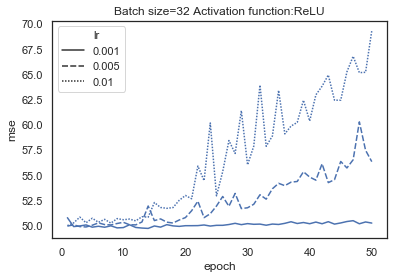

In [41]:
#fixed batch size and activation function
#find the relation betwwen learning rate and mse
sns.lineplot(x='epoch', y='mse',style='lr',
             data=mse[(mse['batch']==32) &
                        (mse['act']=='relu')])
plt.title('Batch size={} Activation function:{}'.format(32,'ReLU'))

Text(0.5, 1.0, 'learning rate=0.001 Batch size=32')

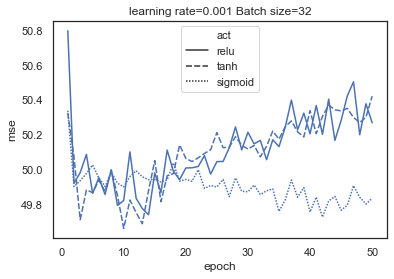

In [42]:
#fixed learning rate and batch size
#find the relation betwwen activation fucntion and mse
sns.lineplot(x='epoch', y='mse',style='act',
             data=mse[(mse['lr']==0.001) &
                     (mse['batch']==32)])
plt.title('learning rate={} Batch size={}'.format(0.001,32))

Text(0.5, 1.0, 'learning rate=0.001 Activation function=relu')

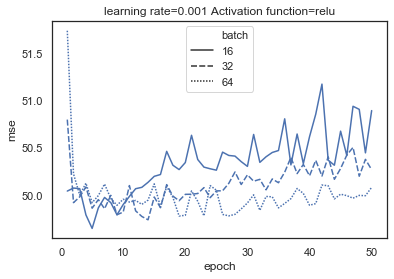

In [43]:
#fixed learning rate and activation function
#find the relation betwwen epoch and mse
sns.lineplot(x='epoch', y='mse',style='batch',
             data=mse[(mse['lr']==0.001) &
                        (mse['act']=='relu')])
plt.title('learning rate={} Activation function={}'.format(0.001,'relu'))

In [9]:
#evaluate
model=Sequential()
model.add(Dense(64, activation='relu', input_dim=32))
model.add(Dense(1))
sgd=optimizers.sgd(lr=0.001)
model.compile(loss='mse',optimizer='sgd')  
model.fit(x_train,y_train,epochs=5,batch_size=16)
model.evaluate(x_test,y_test)

Epoch 1/5
2633/2633 [==============================] - 0s 160us/step - loss: 50.9356
Epoch 2/5
2633/2633 [==============================] - 0s 56us/step - loss: 50.4111
Epoch 3/5
2633/2633 [==============================] - 0s 57us/step - loss: 49.9231
Epoch 4/5
2633/2633 [==============================] - 0s 58us/step - loss: 49.1992
Epoch 5/5
659/659 [==============================] - 0s 106us/step


51.240139875860606

In [11]:
data['Throughput(MB/s)'].mean()

3.4545006702590686